A simple 2-node simulation demonstration the application of GP-CaKe. Of particular interest are the covariance parameters
that define the constraints on the posterior shape of the causal kernels.

References:
    Ambrogioni, L., Hinne, M., van Gerven, M., & Maris, E. (2017). GP CaKe: Effective brain connectivity with causal kernels,
    pp. 1–10. Retrieved from http://arxiv.org/abs/1705.05603

Last updated on July 6th, 2017.

In [1]:
%matplotlib inline
import numpy as np
"""
Simulation and GP-CaKe packages.
"""

import gp_cake.simulator as sim
from gp_cake import gpcake 
from gp_cake import utility
from gp_cake import diagnostics 

Construction of simulated time series data. Here, we start with a 2-node graph with one connection (with max. strength <connection_strength>).

We create a 4 second time series per node, with a sampling rate of 100 Hz. <ntrials_train> trials are then generated to train the dynamic parameters on, and <ntrials_test> to learn the GP posterior.

Note, don't add %%time to the bottom - JL 4/10/2019

In [2]:
p                       = 2
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
connection_strength     = 1.0
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
ntime_points            = int(time_period / time_step)
padding                 = 10
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}
ntrials_train                                       = 200
ntrials_test                                        = 200
simulation                                          = sim.integroDifferential_simulator()

training_samples, training_ground_truth  = simulation.simulate_network_dynamics(ntrials_train, simulation_params)
testing_samples, testing_ground_truth  = simulation.simulate_network_dynamics(ntrials_test, simulation_params)

Generating 200 samples...done (27.47 seconds).
Generating 200 samples...done (24.27 seconds).


Plot a few samples to see the generated time series.

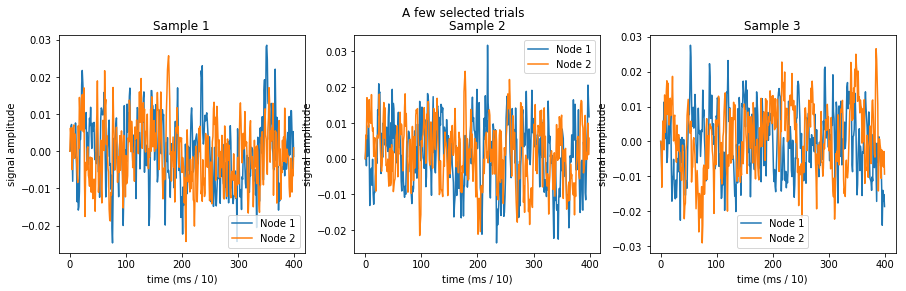

In [3]:
diagnostics.plot_samples(training_samples[0:3])

Simulation is done. Time to bake some cake!

Set up the GP CaKe object and initialize. Currently implemented types of dynamics are 'Relaxation' and 'Oscillation'.

In [4]:
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period, ntime_points)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

Optimize the univariate likelihoods for each node for the dynamic parameters using a grid search.

In [5]:
dynamic_parameters_range = {}
dynamic_parameters_range["relaxation_constant"] = {}
dynamic_parameters_range["relaxation_constant"]["step"] = 2
dynamic_parameters_range["relaxation_constant"]["min"] = 20
dynamic_parameters_range["relaxation_constant"]["max"] = 50
dynamic_parameters_range["amplitude"] = {}
dynamic_parameters_range["amplitude"]["step"] = 0.001
dynamic_parameters_range["amplitude"]["min"] = 0.005
dynamic_parameters_range["amplitude"]["max"] = 0.015

cake.learn_dynamic_parameters(training_samples, dynamic_parameters_range)

Learning parameters of Wiener process...done (315.56 seconds).


Set the parameters of the causal kernel.

In [6]:
cake.set_covariance_parameters(time_scale = 0.2,     
                               time_shift = 0.1,      
                               spectral_smoothing = np.pi,
                               noise_level = 0.05)

# cake.set_covariance_parameters(time_scale = 0.2,     
#                                time_shift = 0.1,      
#                                spectral_smoothing = np.pi,
#                                number_sources = p,
#                                noise_level = 0.05)

Compute the posteriors for each of the p*(p-1) connections.

In [7]:
cake.parallelthreads=1
connectivity = cake.run_analysis(testing_samples)

Computing posterior response functions...done (341.76 seconds).


Visualize the posterior kernels.

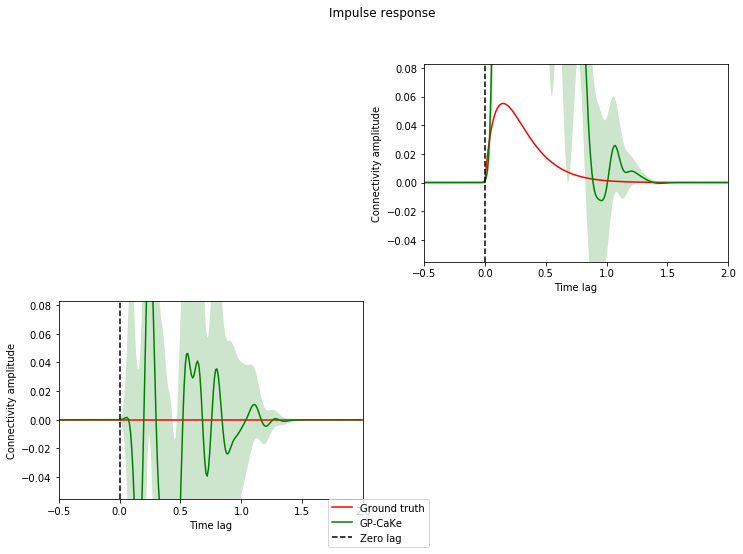

In [8]:
diagnostics.plot_connectivity(testing_ground_truth, connectivity, time_range, t0=-0.5)

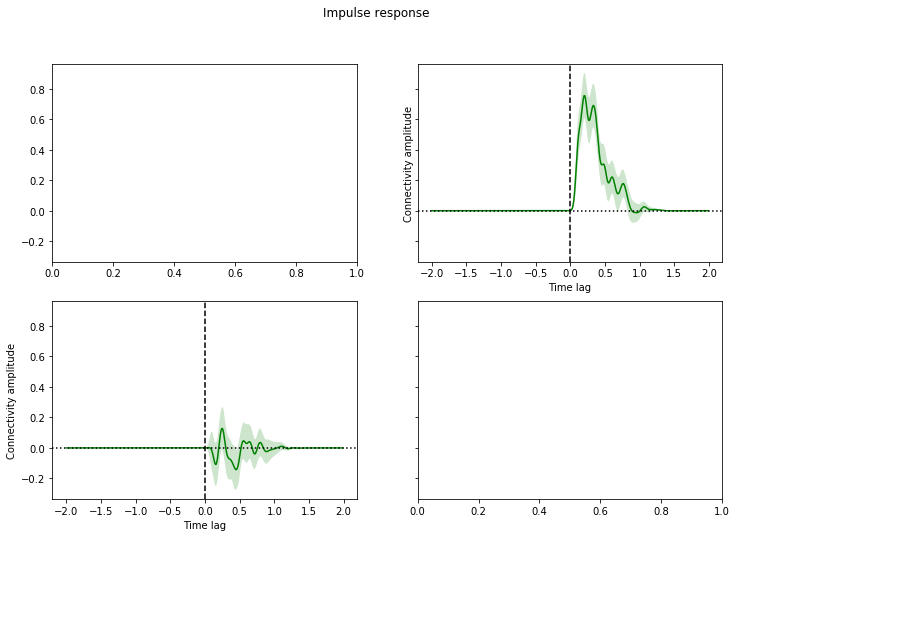

In [9]:
diagnostics.plot_connectivity([], connectivity, time_range, t0=-0.5)